In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
import tensorflow as tf
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import zipfile
import pandas as pd

In [4]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/data/Copy of img_align_celeba.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [18]:
PIC_DIR = f'/tmp/img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open('/tmp/img_align_celeba/' + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 10000/10000 [00:16<00:00, 614.17it/s]


In [19]:
images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


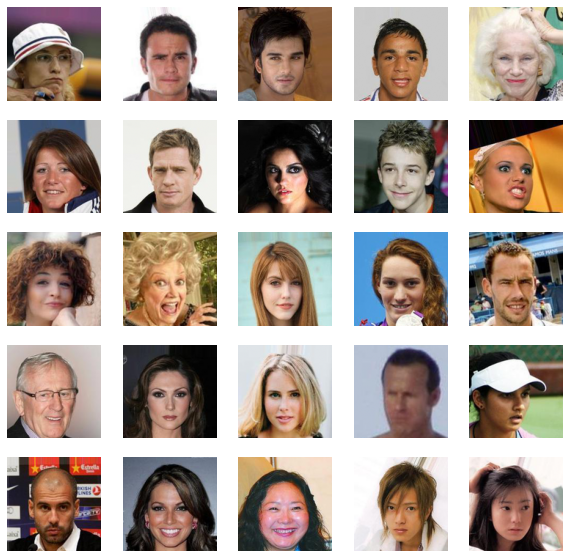

In [47]:
plt.figure(1, figsize=(10, 10))
for i in range(25,50):
    j=i-25
    plt.subplot(5, 5, j+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [21]:
SEED_SIZE = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(SEED_SIZE, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [22]:
generator = create_generator()
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 256)       1048

In [23]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 30, 30, 256)       0   

In [24]:
gan_input = Input(shape=(SEED_SIZE, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [25]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [27]:
gan.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
model_2 (Functional)         (None, 128, 128, 3)       14953987  
_________________________________________________________________
model_3 (Functional)         (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [35]:
import time
iters = 5000
batch_size = 16

GENERATED_IMAGES_PATH = 'GeneratedImages'
FILE_PATH = '%s/generated_%d.png'
os.mkdir(GENERATED_IMAGES_PATH)

control_vectors = np.random.normal(size=(1, SEED_SIZE)) / 2

start = 0
d_losses = []
a_losses = []
count=0
images_saved = 0
for step in range(iters):
    print(count)
    count+=1
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, SEED_SIZE))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, SEED_SIZE))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > 9984:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/tmp/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        control_image = np.zeros((WIDTH, HEIGHT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        control_image[0:WIDTH, 0:HEIGHT, :] = control_generated[0, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (GENERATED_IMAGES_PATH, images_saved))
        images_saved += 1

Streaming output truncated to the last 5000 lines.
99
100/5000: d_loss: 0.7140,  a_loss: 0.9351.  (1.1 sec)
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150/5000: d_loss: 0.6645,  a_loss: 0.7340.  (1.1 sec)
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200/5000: d_loss: 0.6766,  a_loss: 0.7376.  (1.1 sec)
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250/5000: d_loss: 0.7291,  a_loss: 0.7949.  (1.1 sec)
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

In [42]:
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(GENERATED_IMAGES_PATH):
    images_to_gif.append(imageio.imread(GENERATED_IMAGES_PATH + '/' + filename))
imageio.mimwrite('GANFaces4.gif', images_to_gif,fps=5)

In [43]:
!zip -r /content/GeneratedImages.zip /content/GeneratedImages

  adding: content/GeneratedImages/ (stored 0%)
  adding: content/GeneratedImages/generated_28.png (deflated 0%)
  adding: content/GeneratedImages/generated_67.png (stored 0%)
  adding: content/GeneratedImages/generated_61.png (stored 0%)
  adding: content/GeneratedImages/generated_40.png (stored 0%)
  adding: content/GeneratedImages/generated_85.png (stored 0%)
  adding: content/GeneratedImages/generated_22.png (stored 0%)
  adding: content/GeneratedImages/generated_53.png (stored 0%)
  adding: content/GeneratedImages/generated_75.png (stored 0%)
  adding: content/GeneratedImages/generated_31.png (stored 0%)
  adding: content/GeneratedImages/generated_62.png (stored 0%)
  adding: content/GeneratedImages/generated_39.png (deflated 0%)
  adding: content/GeneratedImages/generated_56.png (stored 0%)
  adding: content/GeneratedImages/generated_54.png (stored 0%)
  adding: content/GeneratedImages/generated_84.png (stored 0%)
  adding: content/GeneratedImages/generated_48.png (stored 0%)
  ad

In [44]:
from google.colab import files
files.download("/content/GeneratedImages.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>